In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization
from tensorflow.keras.models import Sequential
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from transformers import ViTModel
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import ViTForImageClassification
from sklearn.metrics import accuracy_score

In [2]:
!pip install --upgrade tensorflow

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 91.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 97.9 MB/s eta 0:00:00:00:01
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.1
    Uninstalling tensorflow-2.16.1:
      Successfully uninstalled tensorflow-2.16.1
ERROR: p

In [3]:
pip install torch torchvision transformers


Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install torchvision transformers


In [5]:
pip install torchinfo


Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [7]:
# Import necessary libraries
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm  # For the progress bar
from transformers import ViTForImageClassification
from torchsummary import summary

In [8]:
# Define image transformation for PyTorch
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define Dataset class
class ViolenceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        label_map = {'violence': 1, 'non_violence': 0}
        for class_dir in os.listdir(root_dir):
            class_dir_path = os.path.join(root_dir, class_dir)
            if class_dir in label_map:
                for sub_dir in os.listdir(class_dir_path):
                    sub_dir_path = os.path.join(class_dir_path, sub_dir)
                    if os.path.isdir(sub_dir_path):
                        for img_name in os.listdir(sub_dir_path):
                            img_path = os.path.join(sub_dir_path, img_name)
                            if os.path.isfile(img_path) and img_name.lower().endswith(('.jpg')):
                                self.images.append(img_path)
                                self.labels.append(label_map[class_dir])
        print(f'Loaded {len(self.images)} images from {root_dir}')

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Instantiate datasets and loaders
train_dataset = ViolenceDataset(root_dir='/kaggle/input/annotated-frame-for-violence-detection/final_frames/train', transform=transform)
val_dataset = ViolenceDataset(root_dir='/kaggle/input/annotated-frame-for-violence-detection/final_frames/validation', transform=transform)
test_dataset = ViolenceDataset(root_dir='/kaggle/input/annotated-frame-for-violence-detection/final_frames/test', transform=transform)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Loaded 23491 images from /kaggle/input/annotated-frame-for-violence-detection/final_frames/train
Loaded 4150 images from /kaggle/input/annotated-frame-for-violence-detection/final_frames/validation
Loaded 4784 images from /kaggle/input/annotated-frame-for-violence-detection/final_frames/test


In [9]:
from collections import Counter

def count_classes(dataset):
    # Use Counter to count occurrences of each label
    labels = [label for _, label in dataset]
    class_counts = Counter(labels)
    return class_counts
print(count_classes(train_dataset))

Counter({0: 13368, 1: 10123})


In [13]:
# Define your ViVIT model
class ViVITModel(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.1):
        super(ViVITModel, self).__init__()
        self.vit = ViTForImageClassification.from_pretrained(
            'google/vit-base-patch16-224',
            num_labels=num_classes,
            ignore_mismatched_sizes=True
        )
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.vit(x).logits
        return self.dropout(x)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create model instance
model = ViVITModel(num_classes=2, dropout_rate=0.1)
model.to(device)

# Print model summary
batch_size = 1
summary(model, input_size=(batch_size, 3, 224, 224), device=device.type)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Layer (type:depth-idx)                                            Output Shape              Param #
ViVITModel                                                        [1, 2]                    --
├─ViTForImageClassification: 1-1                                  [1, 2]                    --
│    └─ViTModel: 2-1                                              [1, 197, 768]             --
│    │    └─ViTEmbeddings: 3-1                                    [1, 197, 768]             742,656
│    │    └─ViTEncoder: 3-2                                       [1, 197, 768]             85,054,464
│    │    └─LayerNorm: 3-3                                        [1, 197, 768]             1,536
│    └─Linear: 2-2                                                [1, 2]                    1,538
├─Dropout: 1-2                                                    [1, 2]                    --
Total params: 85,800,194
Trainable params: 85,800,194
Non-trainable params: 0
Total mult-adds (M): 200.81
Input size (MB)

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification
from torchinfo import summary

# Define your ViVIT model
class ViVITModel(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.1):
        super(ViVITModel, self).__init__()
        self.vit = ViTForImageClassification.from_pretrained(
            'google/vit-base-patch16-224',
            num_labels=num_classes,
            ignore_mismatched_sizes=True
        )
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.vit(x).logits
        return self.dropout(x)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create model instance
model = ViVITModel(num_classes=2, dropout_rate=0.1)
model.to(device)

# Print model summary
batch_size = 1
summary(model, input_size=(batch_size, 3, 224, 224), device=device.type)
print(model)

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets (make sure to change the path to your dataset)
train_dataset = datasets.ImageFolder(root='/kaggle/input/annotated-frame-for-violence-detection/final_frames/train', transform=transform)
val_dataset = datasets.ImageFolder(root='/kaggle/input/annotated-frame-for-violence-detection/final_frames/validation', transform=transform)
test_dataset = datasets.ImageFolder(root='/kaggle/input/annotated-frame-for-violence-detection/final_frames/test', transform=transform)

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# Define training function
def train_model(model, train_loader, val_loader, num_epochs):
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)
    criterion = nn.CrossEntropyLoss()
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct_train_preds, total_train_preds = 0, 0, 0
        
        # Training Phase
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Track training accuracy
            _, predicted = torch.max(outputs, 1)
            correct_train_preds += (predicted == labels).sum().item()
            total_train_preds += labels.size(0)
        
        # Calculate metrics for the epoch
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = correct_train_preds / total_train_preds
        
        # Validation Phase
        val_accuracy = evaluate_model(model, val_loader)
        
        # Print epoch details
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Define evaluation function
def evaluate_model(model, loader):
    model.eval()
    correct_preds, total_preds = 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

    accuracy = correct_preds / total_preds
    return accuracy

# Start training
num_epochs = 10  # Set the number of epochs
train_model(model, train_loader, val_loader, num_epochs)

# Evaluate on test data
test_accuracy = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.4f}")


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViVITModel(
  (vit): ViTForImageClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTSdpaAttention(
              (attention): ViTSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
           

Classification Report:
              precision    recall  f1-score   support

non_violence       0.51      0.55      0.53      2439
    violence       0.49      0.45      0.47      2345

    accuracy                           0.50      4784
   macro avg       0.50      0.50      0.50      4784
weighted avg       0.50      0.50      0.50      4784

Confusion Matrix:
[[1348 1091]
 [1280 1065]]


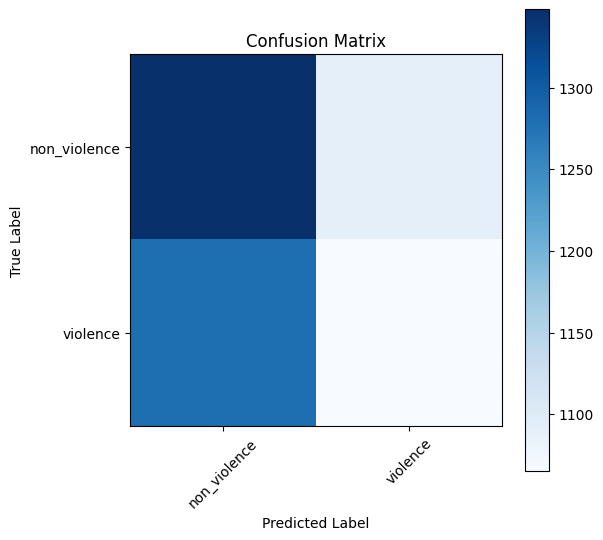

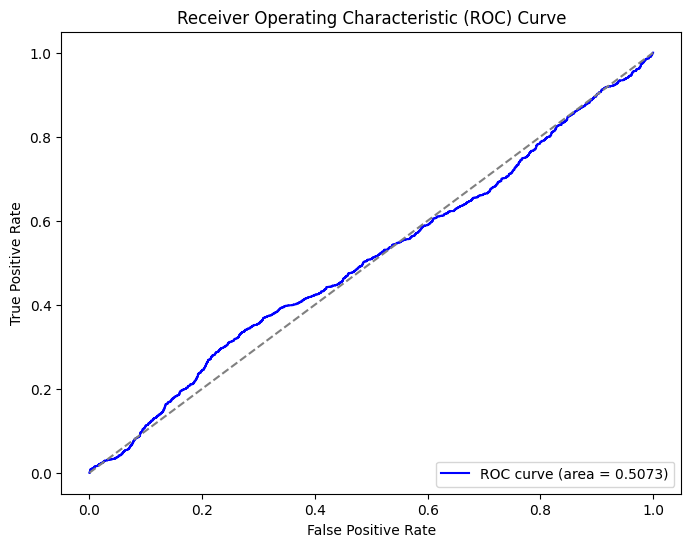

ROC-AUC Score: 0.5073


In [14]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import torch

# Define function to get predictions and labels
def get_predictions_and_labels(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

# Get predictions and labels for test set
test_preds, test_labels = get_predictions_and_labels(model, test_loader)

# Generate classification report
print("Classification Report:")
print(classification_report(test_labels, test_preds, target_names=test_dataset.classes))

# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(test_dataset.classes))
plt.xticks(tick_marks, test_dataset.classes, rotation=45)
plt.yticks(tick_marks, test_dataset.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC-AUC Curve (for binary classification)
if len(test_dataset.classes) == 2:  # Ensure binary classification
    test_probs = []
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)[:, 1]  # Get probabilities for class 1
            test_probs.extend(probabilities.cpu().numpy())

    roc_auc = roc_auc_score(test_labels, test_probs)
    fpr, tpr, _ = roc_curve(test_labels, test_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    print(f"ROC-AUC Score: {roc_auc:.4f}")
else:
    print("ROC-AUC Curve is only applicable for binary classification.")


In [15]:
# Define the path to save the model
model_save_path = "SafeVision_vivit.h5"

# Save the model's state_dict
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to SafeVision_vivit.h5


In [16]:
video_path = '/kaggle/input/v-videos/V_996.mp4'

In [17]:
import cv2

In [18]:
import cv2
import numpy as np
import torch
from torchvision import transforms
from sklearn.metrics import precision_recall_curve

# Define transformations for frames
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Frame-level prediction and temporal smoothing function
def predict_violence(video_path, model, frame_skip=1, smoothing_window=5, device='cpu'):
    cap = cv2.VideoCapture(video_path)
    frame_predictions = []

    # Ensure model is in evaluation mode
    model.eval()
    
    with torch.no_grad():
        while True:
            for _ in range(frame_skip):
                ret, frame = cap.read()
                if not ret:
                    break
            
            if not ret:
                break

            # Preprocess and predict violence probability for each frame
            frame_transformed = transform(frame).unsqueeze(0).to(device)
            outputs = model(frame_transformed)
            probabilities = torch.softmax(outputs, dim=1)
            violence_prob = probabilities[0][1].item()
            frame_predictions.append(violence_prob)
    
    cap.release()
    
    # Apply temporal smoothing to predictions
    smoothed_predictions = np.convolve(frame_predictions, np.ones(smoothing_window) / smoothing_window, mode='valid')
    average_prediction = np.mean(smoothed_predictions)
    print(f"Average Smoothed Violence Probability: {average_prediction:.4f}")

    # Determine video classification based on threshold
    threshold = fine_tune_threshold(model, val_loader, device)
    print(f"Optimal Threshold: {threshold:.4f}")

    if average_prediction >= 0.5:
        print("Prediction: Violence")
    else:
        print("Prediction: Non-Violence")

# Function to find optimal threshold using validation set
def fine_tune_threshold(model, val_loader, device='cpu'):
    model.eval()
    all_probs = []
    all_labels = []

    # Get probabilities and true labels for validation set
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(labels.cpu().numpy())

    # Calculate precision-recall and determine best threshold
    precision, recall, thresholds = precision_recall_curve(all_labels, all_probs)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-7)  # Avoid division by zero
    best_threshold = thresholds[np.argmax(f1_scores)]
    return best_threshold

# Example Usage
# Assuming `model` is loaded and `val_loader` is defined for validation data
video_path =  '/kaggle/input/violence/V_862.mp4'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Call function to predict violence in a video
predict_violence(video_path, model, frame_skip=1, smoothing_window=5, device=device)


Average Smoothed Violence Probability: 0.7037
Optimal Threshold: 0.5143
Prediction: Violence


In [19]:
import cv2
import torch
from torchvision import transforms
from transformers import ViTForImageClassification
from PIL import Image

import torch
from transformers import ViTForImageClassification

# Load your trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels=2,  # Set the number of labels for your task
    ignore_mismatched_sizes=True
)

# Load the state dict
state_dict = torch.load('SafeVision_vivit.h5', map_location=device)

# Modify the state_dict to remove the classifier
state_dict.pop('classifier.weight', None)
state_dict.pop('classifier.bias', None)

# Load the modified state dict into the model
model.load_state_dict(state_dict, strict=False)  # Use strict=False to ignore classifier keys
model.to(device)
model.eval()



# Define the same transformation used during training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def predict_frame(frame):
    image = Image.fromarray(frame).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image)
    
    # Access the logits directly
    logits = outputs.logits  # Get the logits
    return torch.argmax(logits, dim=1).item()  # Get the predicted class index


def analyze_video(video_path):
    cap = cv2.VideoCapture(video_path)
    total_frames = 0
    violence_frames = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        prediction = predict_frame(frame)
        total_frames += 1
        if prediction == 1:  # Assuming '1' corresponds to violence
            violence_frames += 1
    
    cap.release()
    
    if total_frames > 0:
        violence_percentage = (violence_frames / total_frames) * 100
        print(f"Total Frames: {total_frames}, Violent Frames: {violence_frames}, Violence Percentage: {violence_percentage:.2f}%")
    else:
        print("No frames to analyze.")

# Example usage
video_path = '/kaggle/input/nv-videos/NV_999.mp4'  # Ensure this path is correct
analyze_video(video_path)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_30/1142728325.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. Th

Total Frames: 168, Violent Frames: 75, Violence Percentage: 44.64%


In [20]:
print(model)


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [21]:
pretrained_dict = torch.load('SafeVision_vivit.h5', map_location=device)
model_dict = model.state_dict()

# Print keys
print("Keys in the pretrained model:")
print(pretrained_dict.keys())

print("Keys in the current model:")
print(model_dict.keys())


Keys in the pretrained model:
odict_keys(['vit.vit.embeddings.cls_token', 'vit.vit.embeddings.position_embeddings', 'vit.vit.embeddings.patch_embeddings.projection.weight', 'vit.vit.embeddings.patch_embeddings.projection.bias', 'vit.vit.encoder.layer.0.attention.attention.query.weight', 'vit.vit.encoder.layer.0.attention.attention.query.bias', 'vit.vit.encoder.layer.0.attention.attention.key.weight', 'vit.vit.encoder.layer.0.attention.attention.key.bias', 'vit.vit.encoder.layer.0.attention.attention.value.weight', 'vit.vit.encoder.layer.0.attention.attention.value.bias', 'vit.vit.encoder.layer.0.attention.output.dense.weight', 'vit.vit.encoder.layer.0.attention.output.dense.bias', 'vit.vit.encoder.layer.0.intermediate.dense.weight', 'vit.vit.encoder.layer.0.intermediate.dense.bias', 'vit.vit.encoder.layer.0.output.dense.weight', 'vit.vit.encoder.layer.0.output.dense.bias', 'vit.vit.encoder.layer.0.layernorm_before.weight', 'vit.vit.encoder.layer.0.layernorm_before.bias', 'vit.vit.encod

/tmp/ipykernel_30/1202934361.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load('SafeVision_vivit.h5', map_location=device)


In [22]:
for key in model_dict.keys():
    if key not in pretrained_dict:
        print(f"Missing key: {key}")
    elif pretrained_dict[key].shape != model_dict[key].shape:
        print(f"Shape mismatch for key: {key} | Pretrained shape: {pretrained_dict[key].shape}, Current shape: {model_dict[key].shape}")


Missing key: vit.embeddings.cls_token
Missing key: vit.embeddings.position_embeddings
Missing key: vit.embeddings.patch_embeddings.projection.weight
Missing key: vit.embeddings.patch_embeddings.projection.bias
Missing key: vit.encoder.layer.0.attention.attention.query.weight
Missing key: vit.encoder.layer.0.attention.attention.query.bias
Missing key: vit.encoder.layer.0.attention.attention.key.weight
Missing key: vit.encoder.layer.0.attention.attention.key.bias
Missing key: vit.encoder.layer.0.attention.attention.value.weight
Missing key: vit.encoder.layer.0.attention.attention.value.bias
Missing key: vit.encoder.layer.0.attention.output.dense.weight
Missing key: vit.encoder.layer.0.attention.output.dense.bias
Missing key: vit.encoder.layer.0.intermediate.dense.weight
Missing key: vit.encoder.layer.0.intermediate.dense.bias
Missing key: vit.encoder.layer.0.output.dense.weight
Missing key: vit.encoder.layer.0.output.dense.bias
Missing key: vit.encoder.layer.0.layernorm_before.weight
Mis

In [23]:
for key in pretrained_dict.keys():
    if key not in model_dict:
        print(f"Unexpected key: {key}")


Unexpected key: vit.vit.embeddings.cls_token
Unexpected key: vit.vit.embeddings.position_embeddings
Unexpected key: vit.vit.embeddings.patch_embeddings.projection.weight
Unexpected key: vit.vit.embeddings.patch_embeddings.projection.bias
Unexpected key: vit.vit.encoder.layer.0.attention.attention.query.weight
Unexpected key: vit.vit.encoder.layer.0.attention.attention.query.bias
Unexpected key: vit.vit.encoder.layer.0.attention.attention.key.weight
Unexpected key: vit.vit.encoder.layer.0.attention.attention.key.bias
Unexpected key: vit.vit.encoder.layer.0.attention.attention.value.weight
Unexpected key: vit.vit.encoder.layer.0.attention.attention.value.bias
Unexpected key: vit.vit.encoder.layer.0.attention.output.dense.weight
Unexpected key: vit.vit.encoder.layer.0.attention.output.dense.bias
Unexpected key: vit.vit.encoder.layer.0.intermediate.dense.weight
Unexpected key: vit.vit.encoder.layer.0.intermediate.dense.bias
Unexpected key: vit.vit.encoder.layer.0.output.dense.weight
Unexpe

In [24]:
for key, value in model_dict.items():
    print(f"{key}: {value.shape}")


vit.embeddings.cls_token: torch.Size([1, 1, 768])
vit.embeddings.position_embeddings: torch.Size([1, 197, 768])
vit.embeddings.patch_embeddings.projection.weight: torch.Size([768, 3, 16, 16])
vit.embeddings.patch_embeddings.projection.bias: torch.Size([768])
vit.encoder.layer.0.attention.attention.query.weight: torch.Size([768, 768])
vit.encoder.layer.0.attention.attention.query.bias: torch.Size([768])
vit.encoder.layer.0.attention.attention.key.weight: torch.Size([768, 768])
vit.encoder.layer.0.attention.attention.key.bias: torch.Size([768])
vit.encoder.layer.0.attention.attention.value.weight: torch.Size([768, 768])
vit.encoder.layer.0.attention.attention.value.bias: torch.Size([768])
vit.encoder.layer.0.attention.output.dense.weight: torch.Size([768, 768])
vit.encoder.layer.0.attention.output.dense.bias: torch.Size([768])
vit.encoder.layer.0.intermediate.dense.weight: torch.Size([3072, 768])
vit.encoder.layer.0.intermediate.dense.bias: torch.Size([3072])
vit.encoder.layer.0.output.d